# Lending Club Data - Data Prep for H2O.ai Auto ML

**Lending Club** publishes loan data periodically for public use. The anonymized data has information on different loans issued, such as loan_id, loan_amount, what loan grade, credit score etc., and also a **loan_status** variable that indicates whether a loan was _Fully Paid_ ,_Charged Off_ (written off because of default), _Late__by__X__months_ etc., 

This python notebook tutorial shows:
- How to get the data from Lending Club site
- Keep rows for only two classes - to make it a simple binary classification problem
- Drop some Target Leakage Columns
- Create a train and test data set


### Import numpy, pandas, sklearn etc., to do the data munging


In [23]:
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection


### Download 2014 Loan Data from Lending Club Website

The url provided in the wget command is where the 2014 loan data is. You can also get loan data over different periods from https://www.lendingclub.com/info/download-data.action 

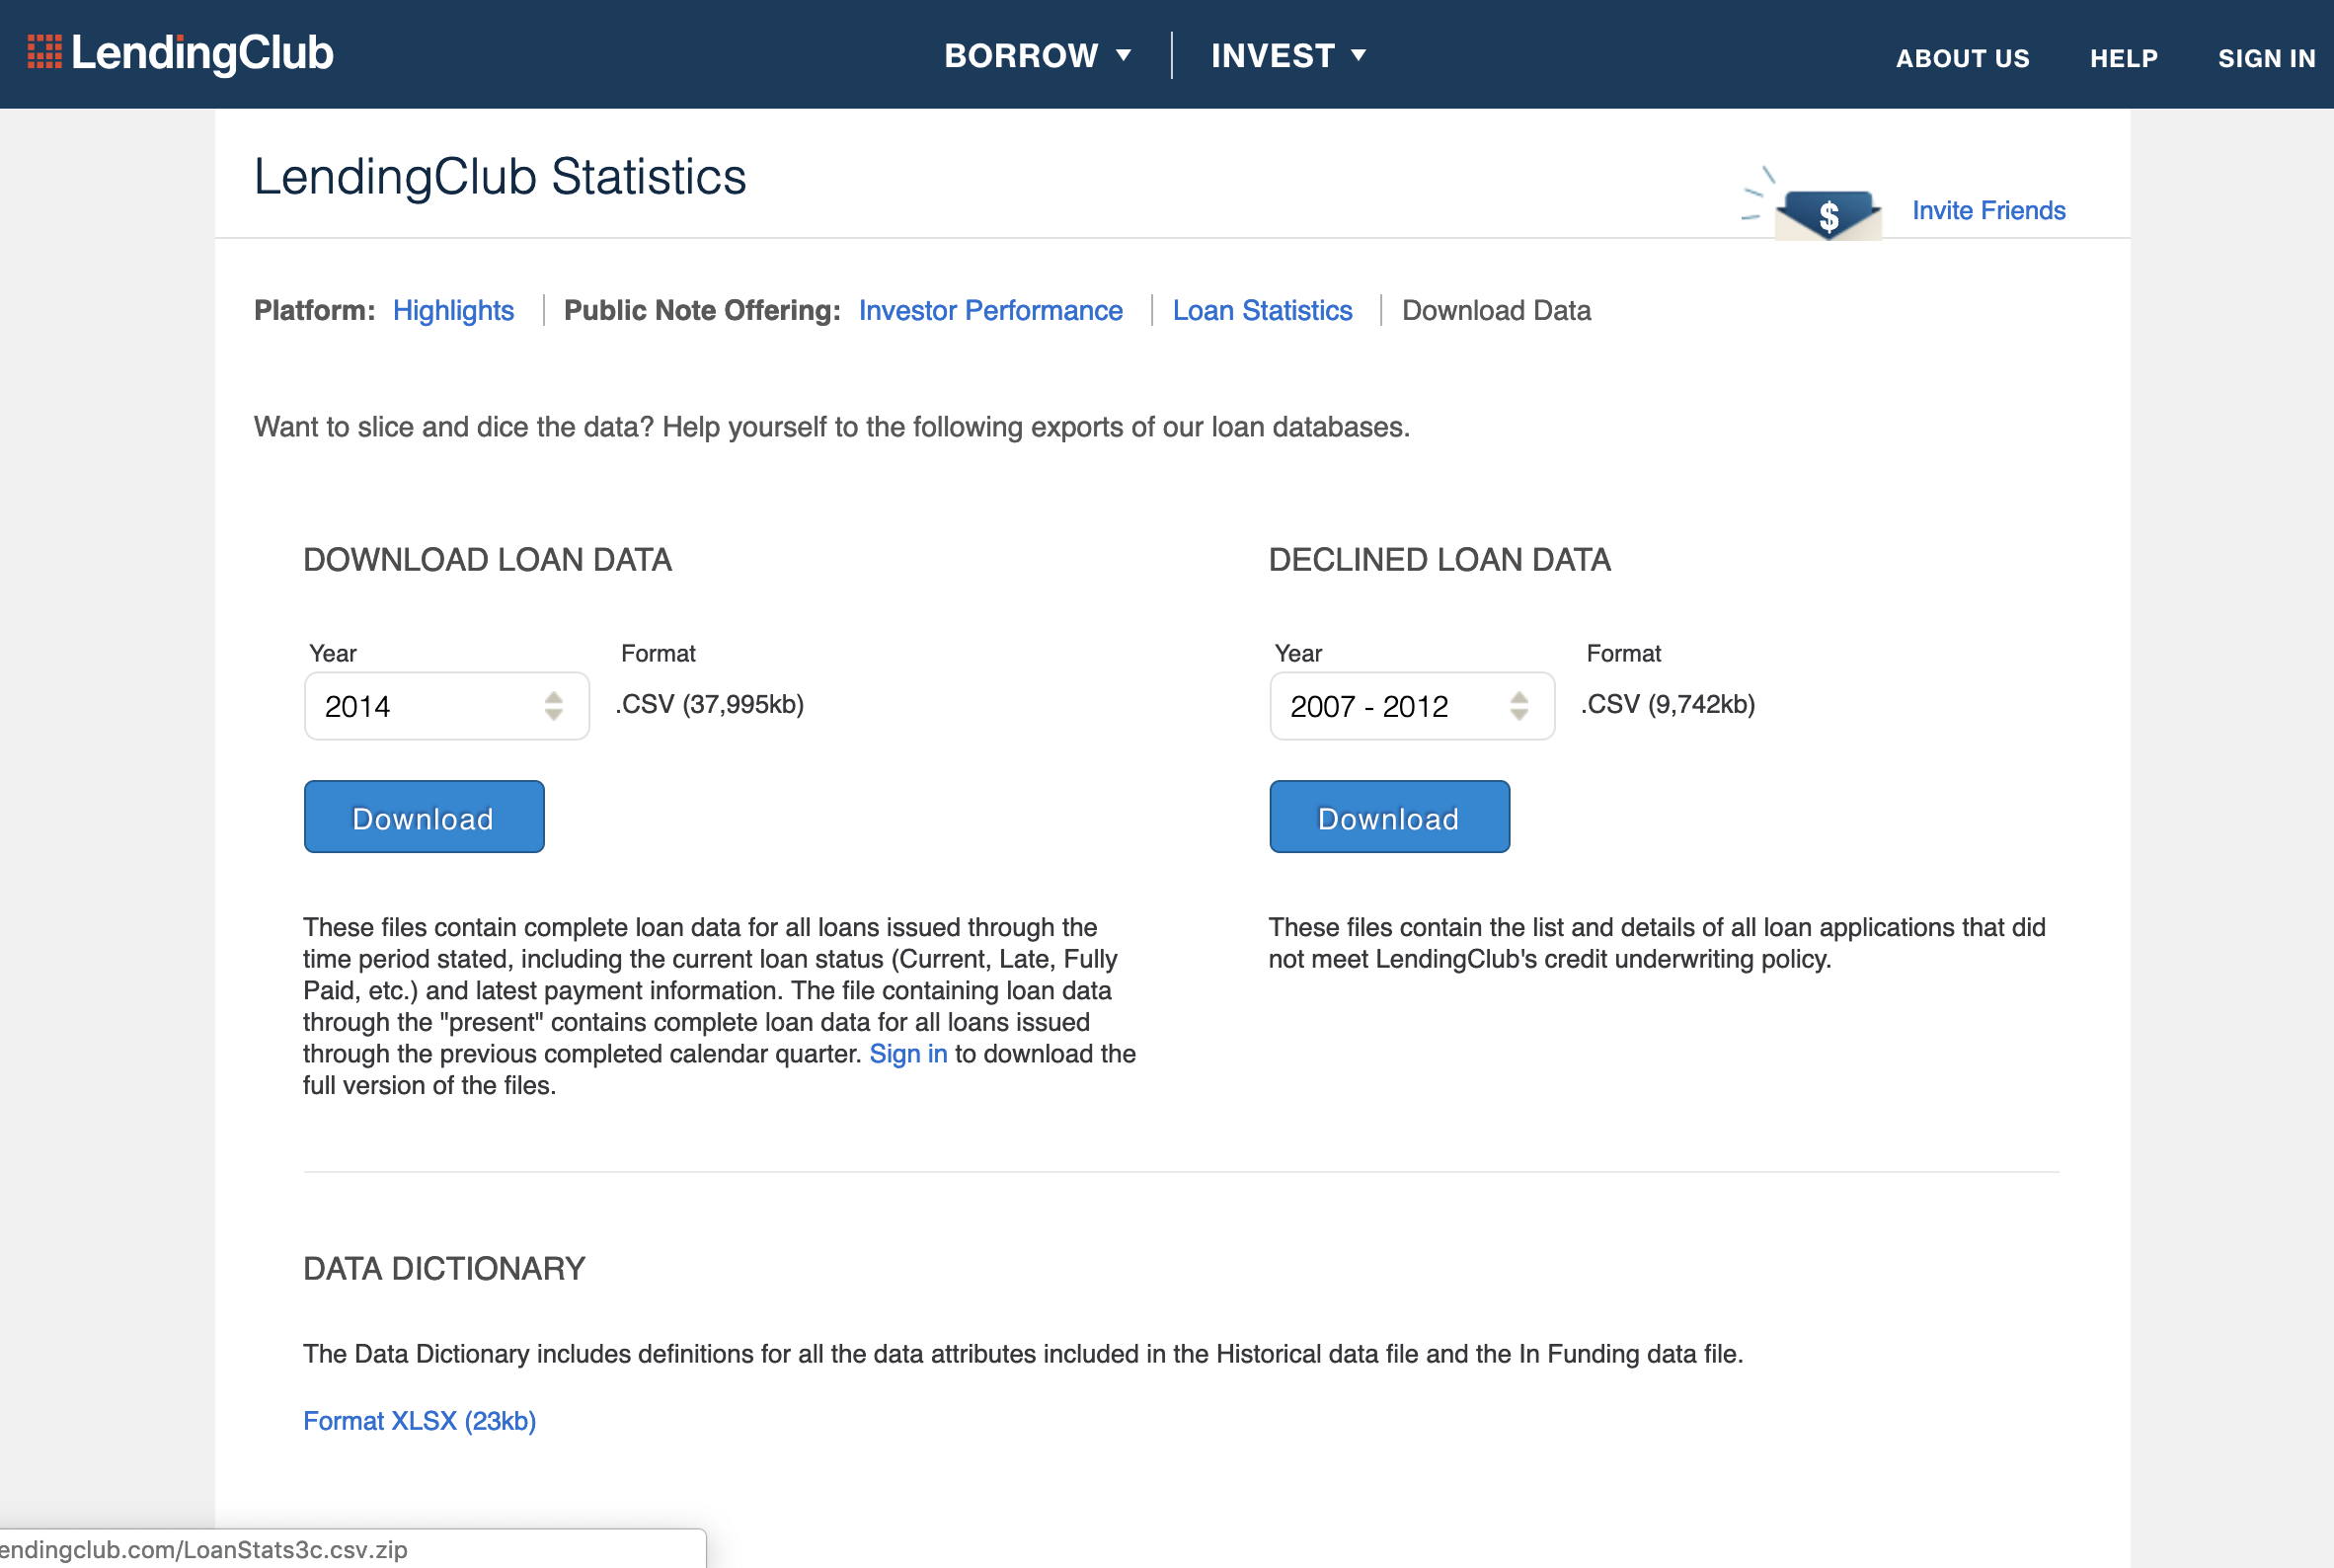

In [24]:
!rm LoanStats3c.csv.zip
!wget --no-check-certificate "https://resources.lendingclub.com/LoanStats3c.csv.zip"

--2019-04-13 08:10:58--  https://resources.lendingclub.com/LoanStats3c.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats3c.csv.zip’

LoanStats3c.csv.zip     [              <=>   ]  37.10M  2.15MB/s    in 25s     

2019-04-13 08:11:23 (1.51 MB/s) - ‘LoanStats3c.csv.zip’ saved [38905597]



### Data Dictionary - for Lending Club Data
We next display the data dictionary of the Lending Club Data. 

Note: Though there are 153 columns in the data dictionary, the actual data (in the next section) has only 145 columns

In [25]:
#!pip install xlrd  # Uncomment this, if you get errors parsing XLSX
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth',9999)
pd.set_option('display.max_columns',9999)
pd.set_option('display.max_rows',9999)
data_dictionary = pd.read_excel("https://resources.lendingclub.com/LCDataDictionary.xlsx")

data_dictionary

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


### Munging the data in Pandas

We first read the data into a Pandas data frame. We skip reading the very first row as it has some non-header information. The target column **loan_status** has really 4 unique values, but we keep only the rows with **Fully Paid** and **Charged Off** status, to make it into a binary classification problem.

In [26]:
# Very first row has non-header data and hence skipping it. Read to a data frame
# Fix the Mon-Year on one column to be readable

def parse_dates(x):
    return datetime.strptime(x, "%b-%d")

lc = pd.read_csv("LoanStats3c.csv.zip", skiprows=1,verbose=False, parse_dates=['issue_d'],low_memory=False) 
lc.shape

(235631, 145)

In [27]:
lc.loan_status.unique()

array(['Charged Off', 'Fully Paid', 'Current', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan],
      dtype=object)

In [28]:
# Keep just "Fully Paid" and "Charged Off" to make it a simple 'Yes' or 'No' - binary classification problem

lc = lc[lc.loan_status.isin(['Fully Paid','Charged Off'])]
lc.loan_status.unique()

array(['Charged Off', 'Fully Paid'], dtype=object)

In [29]:
# Drop the columns from the data frame that are Target Leakage ones
# Target Leakage columns are generally created in hindsight by analysts/data engineers/operations after an outcome 
# was detected in historical data. If we don't remove them now, they would climb to the top of the feature list after a model is built and 
# falsely increase the accuracy to 95% :) 
#
# In Production or real life scoring environment, don't expect these columns to be available at scoring time
# , that is,when someone applies for a loan. So we don't train on those columns ...

ignored_cols = [ 
                'out_prncp',                 # Remaining outstanding principal for total amount funded
                'out_prncp_inv',             # Remaining outstanding principal for portion of total amount 
                                             # funded by investors
                'total_pymnt',               # Payments received to date for total amount funded
                'total_pymnt_inv',           # Payments received to date for portion of total amount 
                                             # funded by investors
                'total_rec_prncp',           # Principal received to date 
                'total_rec_int',             # Interest received to date
                'total_rec_late_fee',        # Late fees received to date
                'recoveries',                # post charge off gross recovery
                'collection_recovery_fee',   # post charge off collection fee
                'last_pymnt_d',              # Last month payment was received
                'last_pymnt_amnt',           # Last total payment amount received
                'next_pymnt_d',              # Next scheduled payment date
                'last_credit_pull_d',        # The most recent month LC pulled credit for this loan
                'settlement_term',           # The number of months that the borrower will be on the settlement plan
                'settlement_date',           # The date that the borrower agrees to the settlement plan
                'settlement_amount',         # The loan amount that the borrower has agreed to settle for
                'settlement_percentage',     # The settlement amount as a percentage of the payoff balance amount on the loan
                'settlement_status',         # The status of the borrower’s settlement plan. Possible values are: 
                                             # COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAF
                'debt_settlement_flag',      # Flags whether or not the borrower, who has charged-off, is working with 
                                             # a debt-settlement company.
                'debt_settlement_flag_date'  # The most recent date that the Debt_Settlement_Flag has been set
                ]

lc = lc.drop(columns=ignored_cols, axis = 1)

In [36]:
# After dropping Target Leakage columns, we have 223K rows and 125 columns
lc.shape

(223102, 125)

### Split to Train and Test - 80%/20%  and write it to two zipped CSV files

In [31]:
import csv
import os 

train_path = os.getcwd() + "/train_lc.csv.zip"
test_path = os.getcwd() + "/test_lc.csv.zip"

train_lc, test_lc = model_selection.train_test_split(lc, test_size=0.2, random_state=10,stratify=lc['loan_status'])
train_lc.to_csv(train_path, index=False,compression="zip")
test_lc.to_csv(test_path, index=False,compression="zip")


In [32]:
# Let's look at the shape of training data
train_lc.shape

(178481, 125)

In [33]:
# Let's look at the shape of test data

In [34]:
test_lc.shape

(44621, 125)

In [35]:
# In the next notebook(s) we will use the training data set to use Automatic Machine Learning to build AI/ML models 
# and will try to predict on the test data set and evaluate the results!